In [1]:
import gc
import os
import glob
import sys
import cv2
import imageio
import joblib
import math
import random
import math
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
from dask import bag, diagnostics 
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
pd.options.plotting.backend = "plotly"
plt.rcParams.update({'font.size': 18})
plt.style.use('fivethirtyeight')

from termcolor import colored

import timm
import torch

import warnings
warnings.simplefilter('ignore')

tqdm.pandas()

# 1. Competition Information

### Competion description 

- **What does Sartorius do?**

Sartorius is a partner of the life science research and the biopharmaceutical industry. They empower scientists and engineers to simplify and accelerate progress in life science and bioprocessing, enabling the development of new and better therapies and more affordable medicine. They're a magnet and dynamic platform for pioneers and leading experts in the field. They bring creative minds together for a common goal: technological breakthroughs that lead to better health for more people.

- **What should we do in this competition?**

In this competition, you’ll detect and delineate distinct objects of interest in biological images depicting neuronal cell types commonly used in the study of neurological disorders. More specifically, you'll use phase contrast microscopy images to train and test your model for instance segmentation of neuronal cells. Successful models will do this with a high level of accuracy.

- **Evaluation**

IoU measures a value obtained by dividing the number of common pixels between the target and the prediction by the total number of pixels.

$$IoU(A,B)= \frac{A \cap B}{A \cup B}$$

# 2. CSV EDA

### file description

In this competition we are segmenting neuronal cells in images. The training annotations are provided as run length encoded masks, and the images are in PNG format. The number of images is small, but the number of annotated objects is quite high. The hidden test set is roughly 240 images.

- **train.csv**
    - **id** : unique identifier for object
    - **annotation** : run length encoded pixels for the identified neuronal cell
    - **width** : source image width
    - **height** : source image height
    - **cell_type** : the cell line
    - **plate_time** : time plate was created 
    - **sample_date** : date sample was created
    - **sample_id** : sample identifier
    - **elapsed_timedelta** : time since first image taken of sample
    
------------------

- **sample_submission.csv** : a sample submission file in the correct format


- **train_semi_supervised** : unlabeled images offered in case you want to use additional data for a semi-supervised approach.


- **LIVECell_dataset_2021** : A mirror of the data from the LIVECell dataset. LIVECell is the predecessor dataset to this competition. You will find extra data for the SH-SHY5Y cell line, plus several other cell lines not covered in the competition dataset that may be of interest for transfer learning.



In [10]:
class CFG:
    base_dir = "./data"
    tr_csv = base_dir + "/train.csv"
    tr_img_path = base_dir + "/train"
    te_img_path = base_dir + "/test"
    tr_semi_path = base_dir + "/train_semi_supervised"

def basic(path):
    df = pd.read_csv(path)
    print(f"Training Dataset Shape: {colored(df.shape, 'blue')}")
    print(f"{colored('--------'*10, 'red')}")
    display(df.info())
    print(f"{colored('--------'*10, 'red')}")
    display(df.head(3))
    print(f"{colored('--------'*10, 'red')}")
    for col in df.columns:
        print(col + ":" + colored(str(len(df[col].unique())), 'blue'))
    return df

In [11]:
train = basic(CFG.tr_csv)

Training Dataset Shape: (73585, 9)
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


None

--------------------------------------------------------------------------------


id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

--------------------------------------------------------------------------------
id:606
annotation:73470
width:1
height:1
cell_type:3
plate_time:8
sample_date:18
sample_id:403
elapsed_timedelta:8


In [12]:
def getImagePaths(path, types):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    print(f"Number of {types} images: {colored(len(image_names), 'yellow')}")
    return image_names

train_images_path = getImagePaths(CFG.tr_img_path, types='train')
test_images_path = getImagePaths(CFG.te_img_path, types='test')
train_semi_supervised_path = getImagePaths(CFG.tr_semi_path, types='train_semi')


Number of train images: 606



Number of test images: 3



Number of train_semi images: 1972


In [13]:
def distribution_plotting(df, col):
    fig = df[col].value_counts().plot.bar(template="simple_white", title=f"[{col}] Bar Chart")
    fig.show()

In [14]:
distribution_plotting(train, 'cell_type')

In [15]:
distribution_plotting(train, 'plate_time')

In [16]:
distribution_plotting(train, 'sample_date')

In [17]:
distribution_plotting(train, 'elapsed_timedelta')

# 3. Display images

In [18]:
def display_img(df, images_paths, rows, cols, types):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(20,20) )
    for ind,image_path in enumerate(images_paths):
        if types == 'train':
            str_id = image_path.split('/')[-1][:-4]
            ct = df.loc[df['id']==str_id, ['cell_type']].values.tolist()[0][0]
        
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            if types == 'train':
                ax.ravel()[ind].set_title(ct)
            else:
                imgp = image_path.split('/')[-1]
                ax.ravel()[ind].set_title(imgp)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

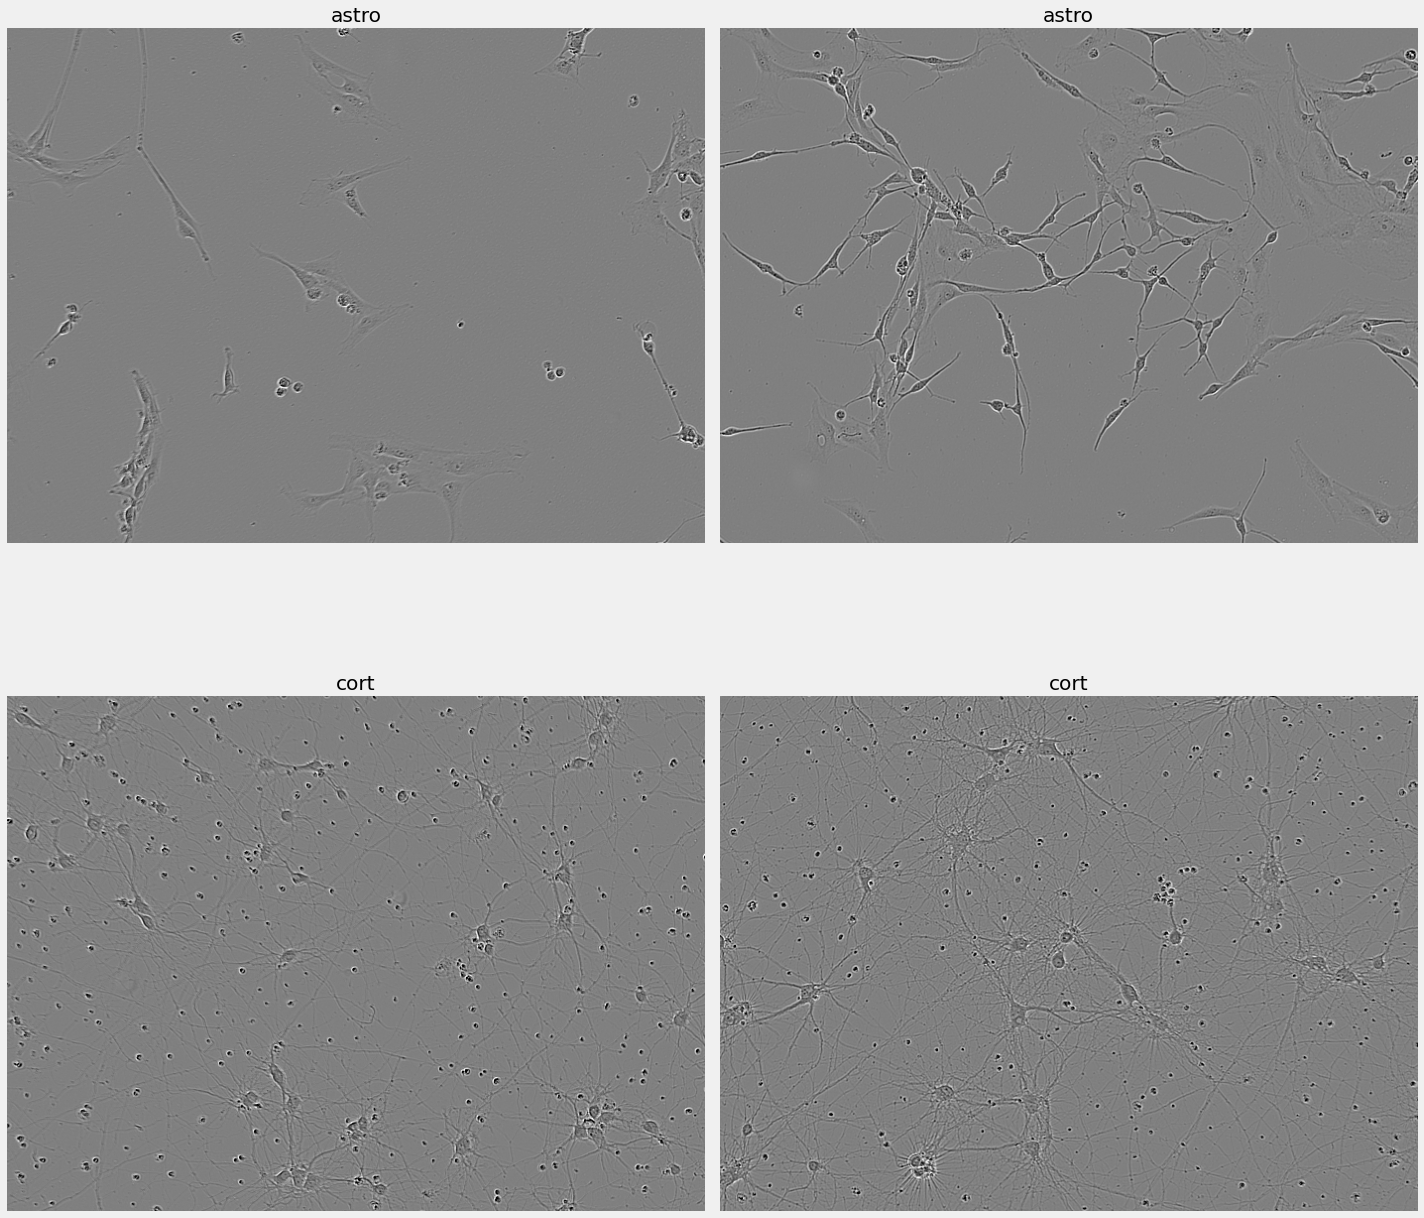

In [19]:
display_img(train, train_images_path, 2, 2, types='train')

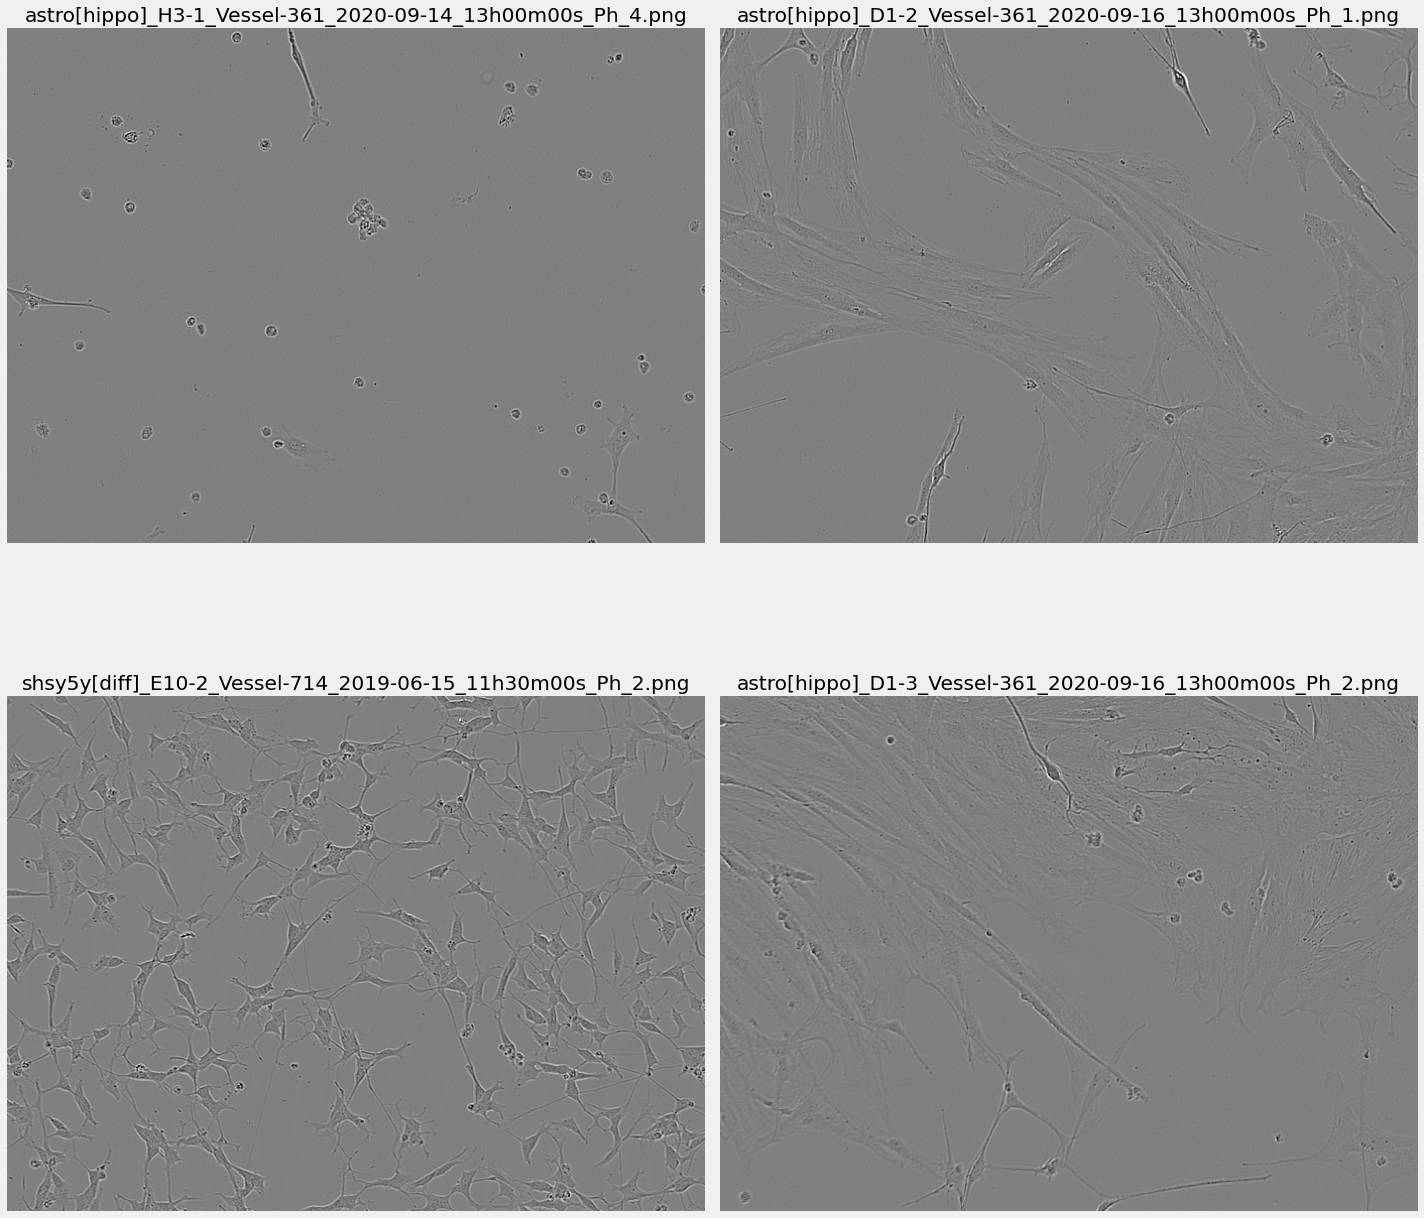

In [20]:
display_img(None, train_semi_supervised_path, 2, 2, types='train_semi')

In [23]:
def rle_decode(mask_rle, shape, color=1):
    s = mask_rle.split()
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    #print(img.shape)        
    for start, end in zip(starts, ends):
        #print(f"{start} ~ {end}")
        #print(img[start : end])
        img[start : end] = color
    
    return img.reshape(shape)

def build_masks(df, image_id, input_shape):
    height, width = input_shape
    labels = df[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

def plot_masks(df, image_id, colors=True):
    labels = df[df["id"] == image_id]["annotation"].tolist()
    cell_type = df[df["id"] == image_id]["cell_type"].tolist()
    cmap = {"shsy5y":(0,0,255),"astro":(0,255,0),"cort":(255,0,0)}

    if colors:
        mask = np.zeros((520, 704, 3))
        for label,cell_type in zip(labels,cell_type):
            c = cmap[cell_type]
            mask += rle_decode(label, shape=(520, 704, 3), color=c)
    else:
        mask = np.zeros((520, 704, 1))
        for label in labels:
            mask += rle_decode(label, shape=(520, 704, 1))
    mask = mask.clip(0, 1)

    image = cv2.imread(f"{CFG.tr_img_path}/{image_id}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(16, 32))
    plt.subplot(3, 1, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(3, 1, 2)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis("off")
    plt.subplot(3, 1, 3)
    plt.imshow(mask)
    plt.axis("off")
    
    plt.show();

1c10ee85de67


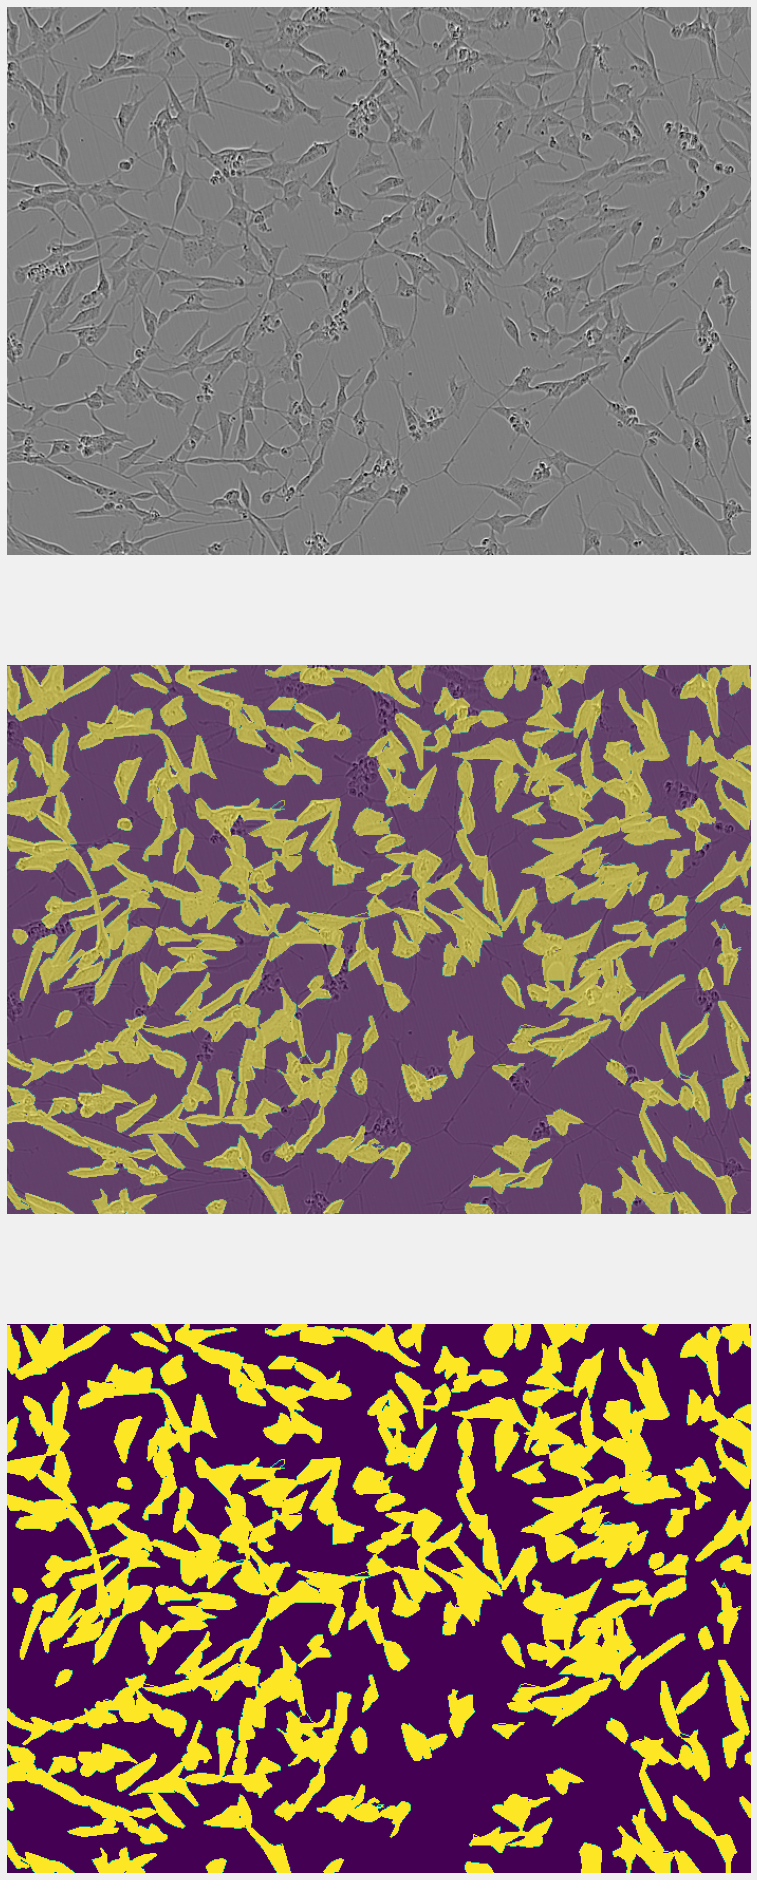

In [24]:
img_id = random.sample(train["id"].values.tolist(), 1)[0]
print(img_id)
plot_masks(train, img_id, colors=False)